<a href="https://colab.research.google.com/github/lovgon/stepik-fast-start_to_AI/blob/main/1_4_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курс "Быстрый старт в искусственный интеллект". 
# Неделя 1. Машинное обучение. 
## 1.4. Выбор оптимальной модели

В этом семинаре мы потренируемся в обучении, оценке и валидации моделей, подборе оптимальных гиперпараметров. Мы будем решать задачу бинарной классификации, а именно, построим алгоритм, определяющий, превысит ли средний заработок человека порог $50000 в год.

В качестве метрики мы будем использовать известную нам метрику ROC-AUC.

## Загрузка и обработка набора данных
Загрузим набор данных из интернета с помощью функции pd.read_csv. Разделим данные на численные и категориальные, удалим из набора строчки с пропущенными значениями.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() #этот метод разделит датасет по колонкам, как в массиве columns

df = df.replace('?', np.nan)

df = df.dropna()

df['salary'] = df['salary'].apply((lambda x: x==' >50K')) # Будем предсказывать 1 (True), если зарплата больше 50K, 0 (False) иначе

In [ ]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
categorial_data.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States


### One-hot кодирование
Поскольку все алгоритмы машинного обучения, которые мы изучили, работают лишь с числовыми признаками, необходимо придумать способ обработки категориальных признаков, переводящий их в числовые. 
Одним из способов сделать это является One-hot кодирование. Его суть состоит в следующем. Пусть некоторая категориальная переменная (скажем, color) принимает $n$ различных значений (Red, Yellow, Green). Тогда можно создать $n$ новыx переменныx, соответствующих различным значениям категориального признака, каждая из которых равна 1 в том случае, если изначальный категориальный признак принимает такое значение, и 0 иначе. Принцип работы иллюстрирован на картинке.

![alt text](https://drive.google.com/uc?id=1B4Q8fpuOFlkQXxD3vHGnMHufqwkTXhk3)

В Pandas One-hot кодирование выполняется функцией pd.get_dummies. Сгенерируем One-hot признаки для нашего датасета. Сохраним полную матрицу объекты признаки в переменную X.

In [ ]:
dummy_features = pd.get_dummies(categorial_data)

In [ ]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,...,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,50,83311,13,0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,28,338409,13,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Выделим целевую переменную в y и вычислим процент единиц в значениях y.

In [ ]:
y = df['salary']
y.mean()

0.24081695331695332

## Разбиение данных на train и test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8)

### Нормировка данных

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Логистическая регрессия
Для логистической регрессии гиперпараметры как правило не так сильно влияют на результат. Запускаем её с параметрами по умолчанию.

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
def plot_roc_curve(model, X_train, X_test, y_train, y_test):
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    plt.figure(figsize=(12,10))

    print(f'Train roc-auc: {roc_auc_score(y_train, y_train_proba)}')
    print(f'Test roc-auc: {roc_auc_score(y_test, y_test_proba)}')


    plt.plot(*roc_curve(y_train, y_train_proba)[:2], label='train roc-curve')
    plt.plot(*roc_curve(y_test, y_test_proba)[:2], label='test roc-curve')

    plt.plot([0,1], [0,1], linestyle='--', color='black')
    plt.grid(True)
    plt.legend()
    plt.show()

Train roc-auc: 0.910145192730874
Test roc-auc: 0.9010417660144299


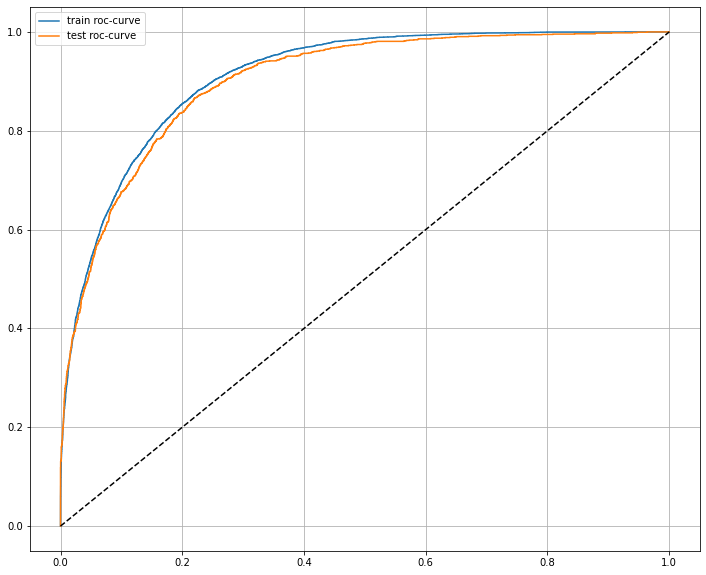

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)

## Выбор модели, подбор гиперпараметра
Для подбора оптимального гиперпараметра будем использовать перебор параметра по сетке. Качество будем измерять с помощью кросс-валидации. 

Суть метода кросс-валидации схематично изображена на картинке.
![alt text](https://drive.google.com/uc?id=1cS2AoSrcG5sCGbnKhkv3ZYqKSmtPd-XM)


Напишем функцию, визуализирующую поиск оптимального гиперпараметра модели по сетке. Для этого используем метод GridSearchCV из sklearn.model_selection.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
def search(X, y, model, param_name, grid, draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='roc_auc', n_jobs=-1)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        plt.plot(grid, means, label='mean values of score')

        plt.fill_between(grid, means - 2 * error, means + 2 * error, color='green', label='deviation area between errors')
        plt.legend()
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

Протестируем функцию на KNN и решающем дереве.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

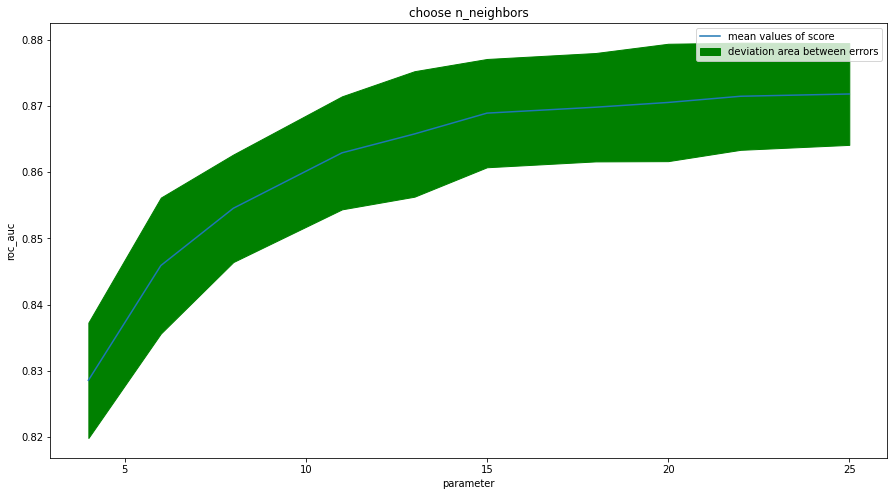

In [ ]:
models = [KNeighborsClassifier(n_jobs=-1)]
param_names = ['n_neighbors']
grids = [np.array(np.linspace(4, 25, 10), dtype='int')]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search(X_train, y_train, model, param_name, grid, param_scale)

Train roc-auc: 0.8971232035795839
Test roc-auc: 0.870414837593795


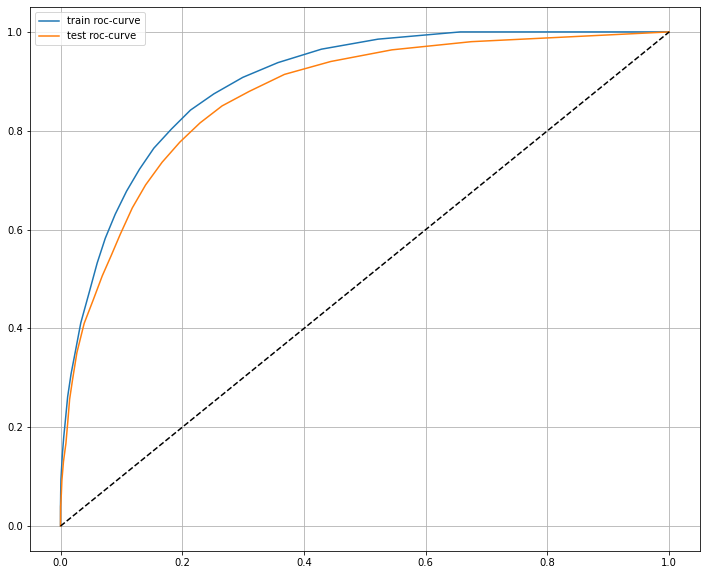

In [ ]:
model = KNeighborsClassifier(n_neighbors=25, n_jobs=-1).fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)

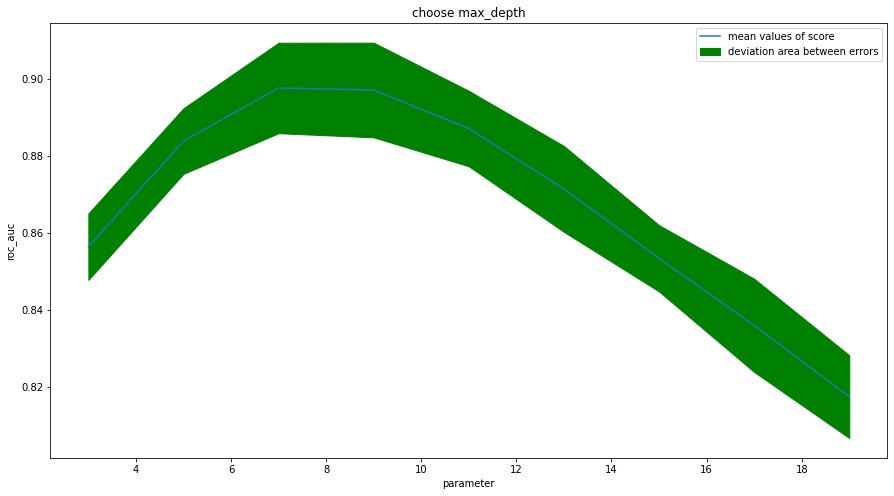

In [ ]:
models = [DecisionTreeClassifier()]
param_names = ['max_depth']
grids = [np.arange(3, 21, 2)]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search(X_train, y_train, model, param_name, grid, param_scale) 

Train roc-auc: 0.9096308063903111
Test roc-auc: 0.8936026699523388


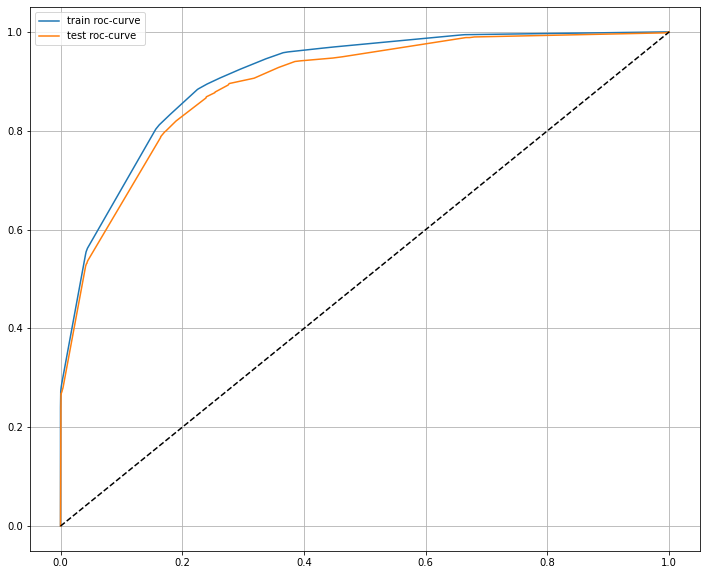

In [ ]:
model = DecisionTreeClassifier(max_depth=7).fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)

### Случайный лес

Подберём параметр n_estimators в алгоритме случайный лес. Известно, что случайный лес не переобучается. Поэтому график качества будет монотонно возрастать. Следовательно, необходимо найти минимальное значение n_estimators, при котором качество не изменяется. 
Поскольку каждое дерево обучается независимо от остальных, достаточно обучить сразу лес из большого количества деревьев, а затем рассмотреть подмножества нужного размера из исходного множества деревьев.

Мы не будем так делать ввиду излишней сложности получаемого кода.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
models = [RandomForestClassifier(n_jobs=-1)]
param_names = ['n_estimators']
grids = [[10, 20, 30, 50, 75, 100, 150]]
param_scales = ['ordinary']

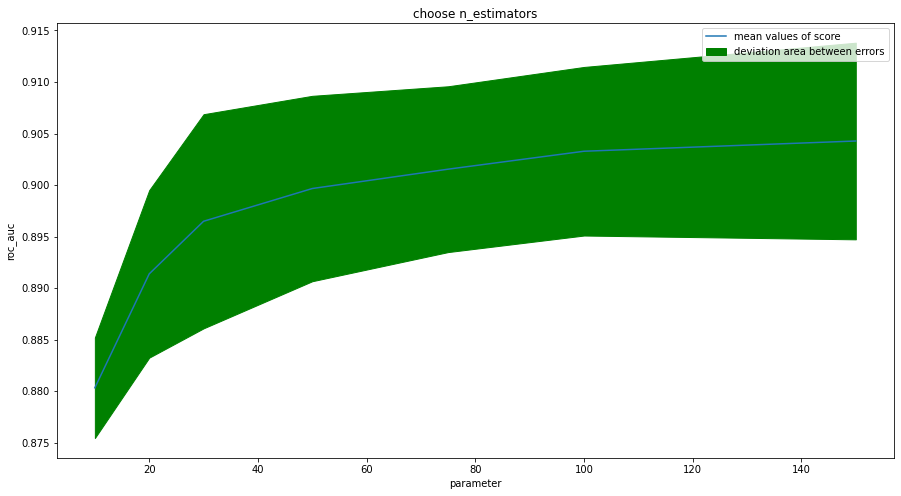

In [ ]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search(X_train, y_train, model, param_name, grid, param_scale)

Как и следовало ожидать, случайный лес побил оба предыдущих алгоритма. Вычислим итоговое качество на test.

Train roc-auc: 0.9999999879053294
Test roc-auc: 0.8982618115361118


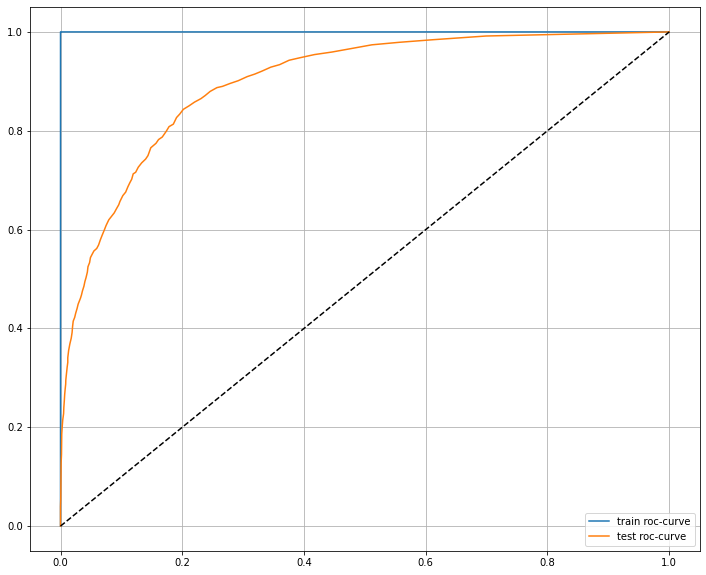

In [ ]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)

### Что ещё можно делать.

Мы подбирали оптимальный одномерный параметр для алгоритма. Можно также:

* Искать по сетке не только численные гиперпараметры, но и категориальные, например, метрику в алгоритме ближайших соседей или критерий ветвления в решающем дереве.

* Искать оптимальный параметр по многомерной сетке. Перебрать все возможные варианты здесь не выйдет, потому что на это уйдёт слишком много времени. Зато можно перебирать случайные точки по сетке. Эта процедура называется Grid Random Search.

# Бустинг

Подберём параметр max_depth для градиентного бустинга

In [ ]:
import xgboost

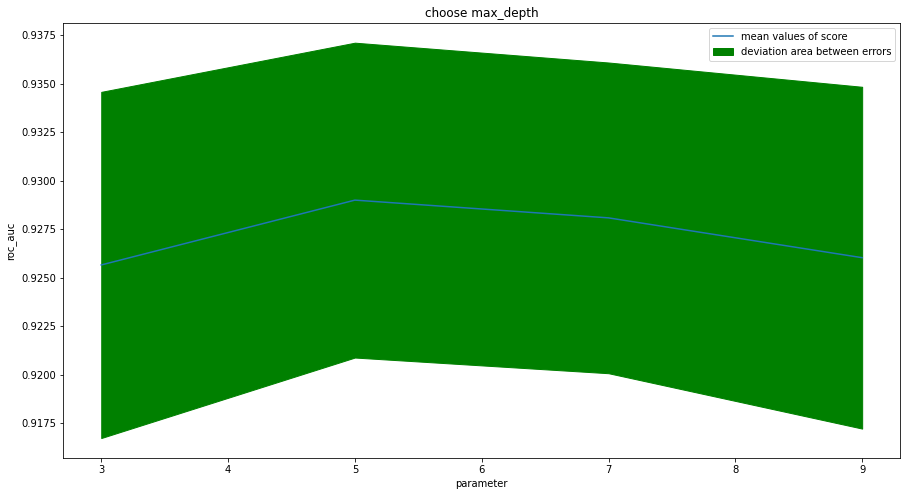

In [ ]:
models = [xgboost.XGBClassifier(n_estimators=200)]
param_names = ['max_depth']
grids = [np.arange(3,10,2)]
param_scales = ['ordinary']

for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search(X_train, y_train, model, param_name, grid, param_scale)

Train roc-auc: 0.9525599527378976
Test roc-auc: 0.9262627369202493


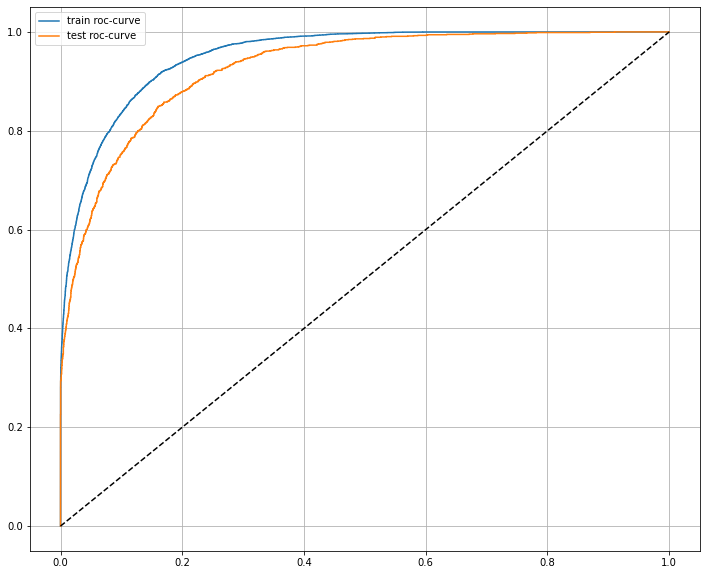

In [ ]:
model = xgboost.XGBClassifier(max_depth=5, n_estimators=300).fit(X_train, y_train)
plot_roc_curve(model, X_train, X_test, y_train, y_test)